Load Data

Env Import

In [670]:
import torch
import gpytorch
import numpy as np
from scipy import io
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [671]:
io.loadmat("./data/datatest.mat").keys()

dict_keys(['__header__', '__version__', '__globals__', 'f', 'x', 'xstar', 'y', '__function_workspace__'])

In [672]:
x = io.loadmat("./data/datatest.mat")['x']
x = torch.DoubleTensor(x).squeeze()
x

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15.], dtype=torch.float64)

In [673]:
y = io.loadmat("./data/datatest.mat")['y']
y = torch.DoubleTensor(y).squeeze()
y

tensor([ 1328.8584, -1538.5099, -2236.9759, -2002.1924, -3461.1936,   568.7126,
        -1298.4263, -3824.9355, -3232.8616, -6269.4363, -3948.5925, -2673.4484,
         -820.2672,   628.3100,  2076.9202], dtype=torch.float64)

In [674]:
xstar = io.loadmat("./data/datatest.mat")['xstar']
xstar = torch.DoubleTensor(xstar).squeeze()

In [675]:
x.shape

torch.Size([15])

# Prior Sampling

## (a) Kernel

### Hyperparameter Setting

In [41]:
a = 5
l = 20

### ExactGPModel

In [690]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel, a=5, l=20, scale=True):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.scale = scale
        self.mean_module = gpytorch.means.ConstantMean()
        if self.scale and type(kernel).__name__ not in ["BMKernel"]:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel)
            self.covar_module.outputscale = a
            if self.covar_module.base_kernel.has_lengthscale:
                self.covar_module.base_kernel.lengthscale = l
        else:
            self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Sample Test

In [43]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x, None, likelihood, OUKernel())

In [44]:
model.covar_module.base_kernel.lengthscale

tensor([[20.]], grad_fn=<SoftplusBackward>)

In [45]:
test_data = torch.Tensor([[i] for i in range(1, 101)])

In [46]:
test_data.shape

torch.Size([100, 1])

In [47]:
gpytorch.settings.prior_mode(True)
model.eval()
samples = model(test_data).sample()

### Kernel Define

In [48]:
class BMKernel(gpytorch.kernels.Kernel):
    has_lengthscale = False
    def __init__(self, **kwargs):
        super(BMKernel, self).__init__(has_lengthscale=False, **kwargs)

    def forward(self, x1, x2, diag=False, **params):
        N = x1.shape[0]
        x1 = x1.repeat(1,N)
        x2 = x2.T.repeat(N,1)
        res = torch.min(x1, x2)
        return res

In [49]:
t = torch.Tensor([[i] for i in range(10)])

In [50]:
x1 = t
x2 = t
N = x1.shape[0]
x1 = x1.repeat(1,N)
x2 = x2.T.repeat(N,1)
res = torch.min(x1, x2)
print(res)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 2., 2., 2., 2., 2., 2., 2., 2.],
        [0., 1., 2., 3., 3., 3., 3., 3., 3., 3.],
        [0., 1., 2., 3., 4., 4., 4., 4., 4., 4.],
        [0., 1., 2., 3., 4., 5., 5., 5., 5., 5.],
        [0., 1., 2., 3., 4., 5., 6., 6., 6., 6.],
        [0., 1., 2., 3., 4., 5., 6., 7., 7., 7.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 8.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])


In [51]:
kernel = BMKernel()
kernel.has_lengthscale
model = ExactGPModel(x, None, likelihood, BMKernel())

#### OUKnernel

In [52]:
class OUKernel(gpytorch.kernels.Kernel):
    has_lengthscale = True
    def __init__(self, **kwargs):
        super(OUKernel, self).__init__(has_lengthscale=True, **kwargs)
        self.has_lengthscale = True

    def forward(self, x1, x2, diag=False, **params):

        x1_ = x1.div(self.lengthscale ** (0.5))
        x2_ = x2.div(self.lengthscale ** (0.5))
        diff = self.covar_dist(x1_, x2_, diag=diag, **params)
        res = diff.div(-1).exp_()
        return res

In [53]:
class IQKernel(gpytorch.kernels.Kernel):
    has_lengthscale = True
    def __init__(self, **kwargs):
        super(IQKernel, self).__init__(has_lengthscale=True, **kwargs)
        self.has_lengthscale = True
        self.c = 1
    def postprocess_rbf(self, dist_mat):
        return torch.sqrt(self.c + dist_mat)
    def forward(self, x1, x2, diag=False, **params):
        # if (
        #     x1.requires_grad
        #     or x2.requires_grad
        #     or (self.ard_num_dims is not None and self.ard_num_dims > 1)
        #     or diag
        #     or params.get("last_dim_is_batch", False)
        #     or trace_mode.on()
        # ):
            x1_ = x1.div(self.lengthscale)
            x2_ = x2.div(self.lengthscale)
            return self.covar_dist(
                x1_, x2_, square_dist=True, diag=diag, dist_postprocess_func=self.postprocess_rbf, postprocess=True, **params
            )
        # return RBFCovariance.apply(
        #     x1,
        #     x2,
        #     self.lengthscale,
        #     lambda x1, x2: self.covar_dist(
        #         x1, x2, square_dist=True, diag=False, dist_postprocess_func=postprocess_rbf, postprocess=False, **params
        #     ),
        # )

In [54]:
per_kernel = gpytorch.kernels.PeriodicKernel()
# test_data = xstar
# print(test_data.shape)
kernel_dict = {
    "BM": BMKernel(),
    "RBF": gpytorch.kernels.RBFKernel(),
    # "ARD": gpytorch.kernels.RBFKernel(ard_num_dims=test_data.shape[1]),
    "OU": OUKernel(),
    "PER": per_kernel,
    "IQ": IQKernel()
}

### Plot Function

In [641]:
def draw_kernel_figure(a=5, l=20):
    per_kernel = gpytorch.kernels.PeriodicKernel()
    # per_kernel.period_length = 3
    kernel_dict = {
            "BM": BMKernel(),
            "RBF": gpytorch.kernels.RBFKernel(),
            "ARD": gpytorch.kernels.RBFKernel(ard_num_dims=test_data.shape[1]),
            "OU": OUKernel(),
            "PER": per_kernel,
            "IQ": IQKernel()
        }
    plt.figure(figsize=(5, 5))
    for kernel_name, kernel in kernel_dict.items():
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(None, None, likelihood, kernel,  a=a, l=l)
        gpytorch.settings.prior_mode(True)
        model.eval()
        samples = model(test_data).sample(sample_shape=torch.Size((1,)))
        for sample in samples:
            
            plt.plot(test_data, sample, label=kernel_name)

    plt.title("Prior_Sampling, "+"a^2="+str(a)+", l="+str(l))
    plt.xlabel("test_data")
    plt.ylabel("y")
    plt.legend()

In [647]:
def draw_IQ_kernel_figure(a=5, l=20, c=1):
    kernel = IQKernel()
    kernel.c = c
    plt.figure(figsize=(5, 5))
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(None, None, likelihood, kernel,  a=a, l=l)
    gpytorch.settings.prior_mode(True)
    model.eval()
    samples = model(test_data).sample(sample_shape=torch.Size((1,)))
    kernel_name = "IQ Kernel"
    for sample in samples:
        plt.plot(test_data, sample, label=kernel_name)
    plt.title("IQ Kernel Prior_Sampling, "+"a^2="+str(a)+", l="+str(l)+ ", c="+str(c))
    plt.xlabel("test_data")
    plt.ylabel("y")
    plt.legend()

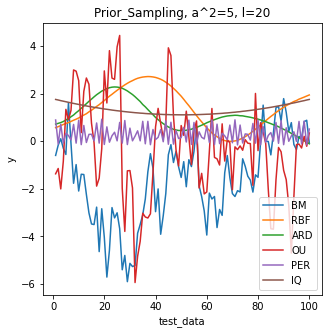

In [643]:
draw_kernel_figure(a=5, l=20)

## (b) Vary Hyperparameters
item (6 marks): Comment on the behaviour of the distribution over prior functions as you vary the hyperparameters $a$, $\ell$, and $\alpha$, with both analytic and empirical support (plots of sample prior functions) for your reasoning.

### Parameter Explanation (Analytically)

<!-- %%latex -->

Kerner hyperparameters $a$, $\ell$, and $\alpha$ or c.

**{Lengthscale $\ell$}**

Lengthscale $\ell$, a larger lengthscale means that the learnt function varies less in that direction, the input is more correlated, which means that that feature is irrelevant for the learnt function. In other word, a small lengthscale will make the samples $f(1)$ and $f(2)$ less correlated.

**{Scale $a^2$}**

Scale $a^2$ is a scaler parameter for the kernel which can adjust the output range of kernel. For large values, the range of f functin output will be large magnitude.
Fro small value of $a^2$, the range of f function output will be scaled to a small range.

**{IQ hyperparameter c}**

C is like given a mean or basis for the distance measure, a larger c will make the difference of distance less dominate, while a small c will make the the difference of distance more significant.

### Varing Lengthscale l

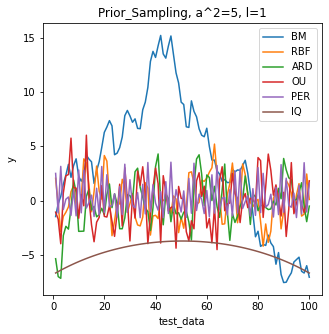

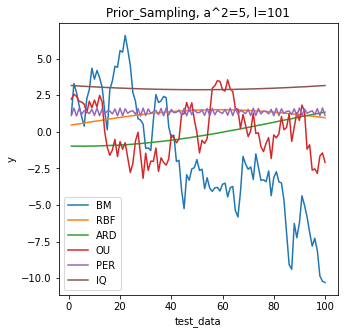

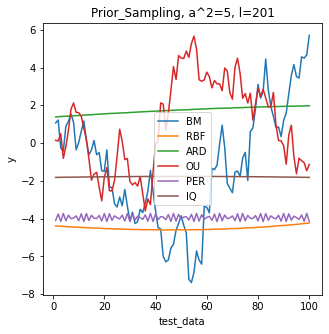

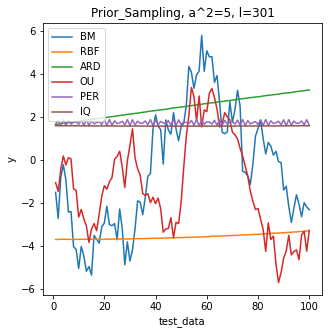

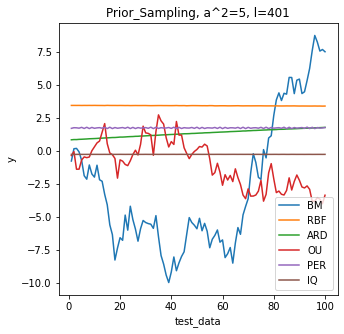

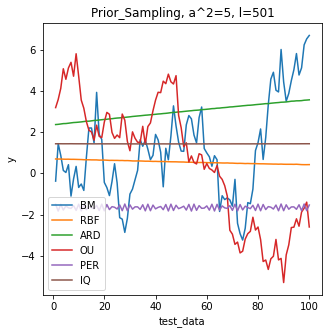

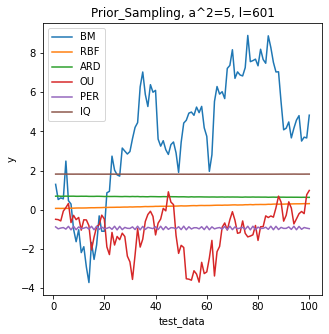

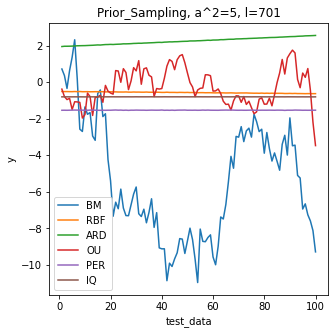

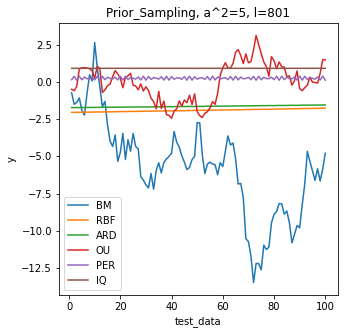

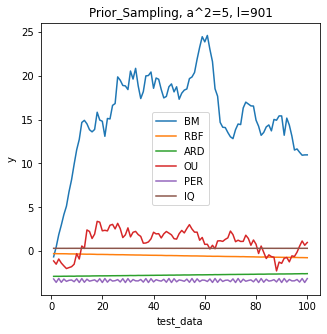

In [644]:
for i in range(1,1000,100):
    draw_kernel_figure(a=5, l=i)

#### Parameter l Varing Result Explanation (Empirically)

With small l, we can notice that the data have a strong prior trend, which indicate that samples are strong related to others.

With large l, we can observe that data variance is large and share less information with each other.

Interestingly, we can get RBF and PER do not change a lot with the l comparing to PER.

Generally, l will give our prior beleif about the data - whether such kernel structure can fit the data well or not. In other words, such feature is important to the model or not.

### Varing a^2

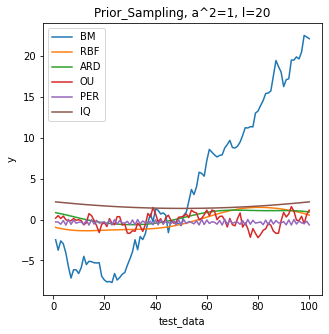

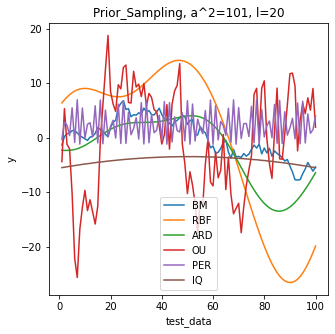

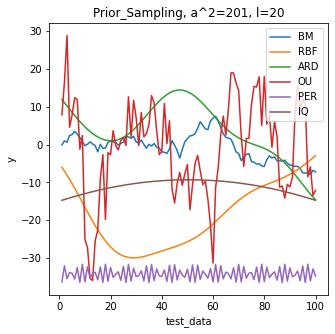

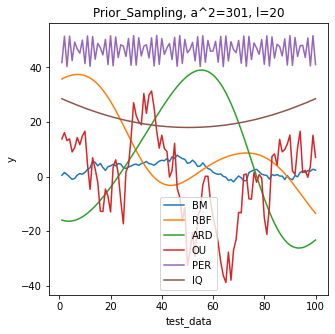

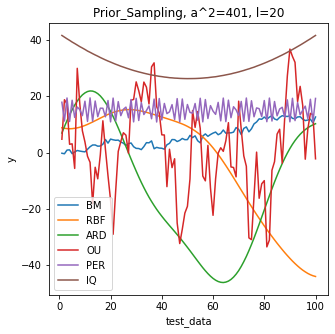

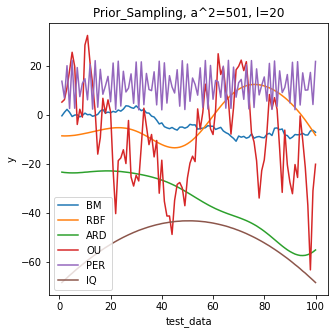

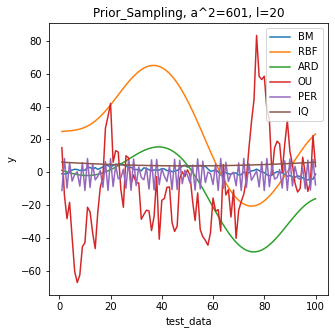

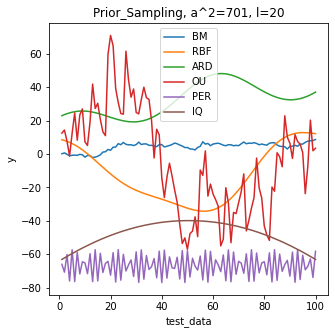

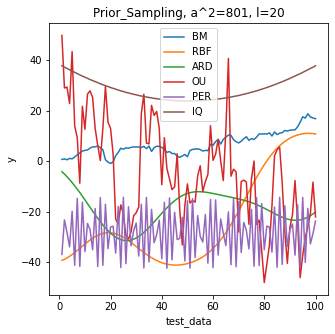

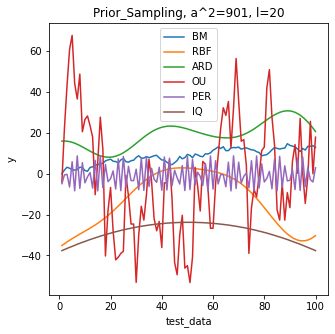

In [645]:
for a in range(1,1000,100):
    draw_kernel_figure(a=a, l=20)

#### Parameter a Varing Result Explanation (Empirically)

a adjust the output range.

Large a will amplify the original kernel output difference.

From the figure, we can notice that PER is the one with largest difference for different a. 

### Varing c

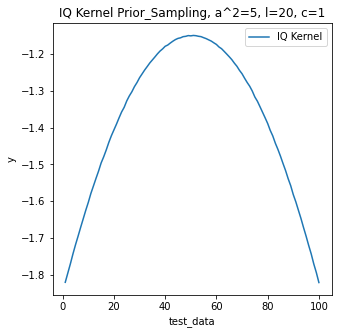

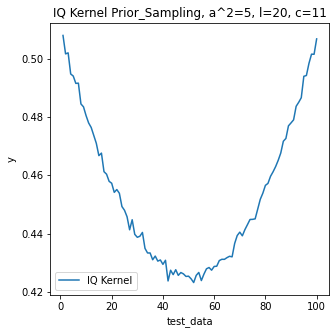

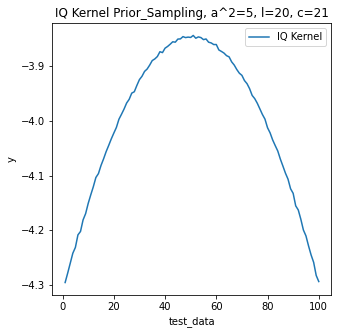

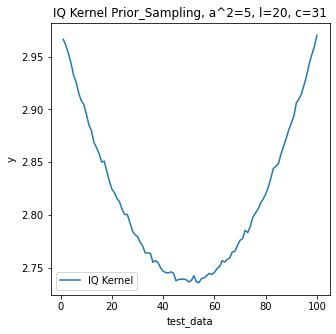

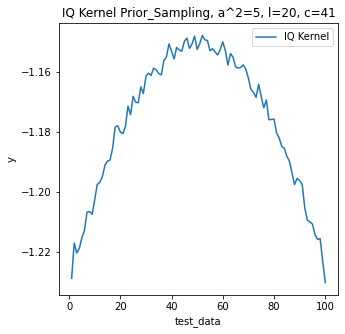

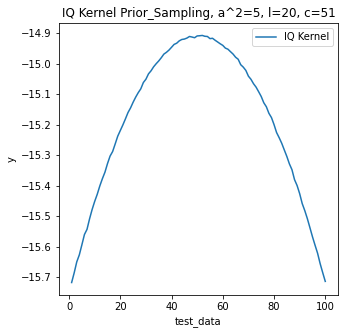

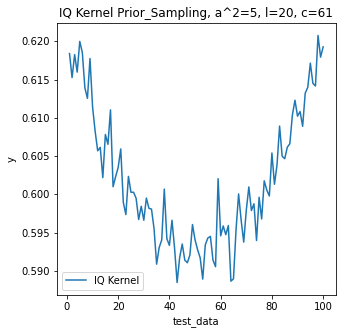

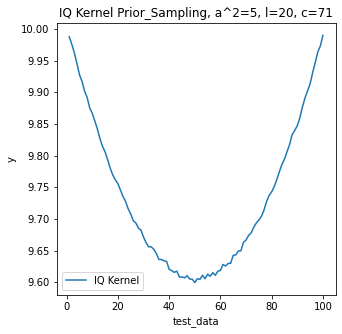

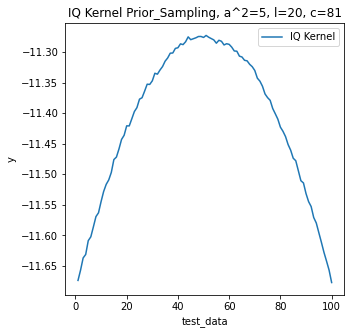

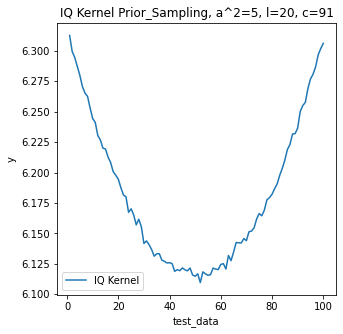

In [648]:
for c in range(1,100,10):
    draw_IQ_kernel_figure(a=5,l=20,c=c)

#### Parameter c Varing Result Explanation (Empirically)

We can observe that small c will lead to a larger output range (the difference between kernel items is more significant) 

large c will make all the output almost the same.

# Posterior Sampling

Before fitting the data, be sure to subtract the empirical mean from the data, to fit your modelling assumptions.  When you make predictions with the GP, add back on the empirical mean. 

### About dataset transform

**Comment**:
I tried to use zeromean(with modifying y to y-emprical mean) and constant mean with modification of the data, the result is similar.

So here we use the original dataset and constant mean model **without** data transform

## hyperparameter setting

In [694]:
l = 5
y_mean = y.mean()
# a = torch.std(y,dim=0)
a = y.var()
sigma = 900 ** 2

### Data Transform

In [695]:
def norm(y):
    y_normed = (y - y_mean)/a
    return y_normed

In [696]:
def denorm(y_normed):
    y = a * y_normed + y_mean 
    return y

In [697]:
empirical_mean = y.mean()
y_zero_centered = y - empirical_mean

In [698]:
y_normed = norm(y)
y_normed

tensor([ 6.0370e-04,  4.6942e-05, -8.8679e-05, -4.3091e-05, -3.2638e-04,
         4.5610e-04,  9.3559e-05, -3.9701e-04, -2.8205e-04, -8.7166e-04,
        -4.2102e-04, -1.7343e-04,  1.8640e-04,  4.6767e-04,  7.4895e-04],
       dtype=torch.float64)

In [699]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = sigma
rbf_model = ExactGPModel(x, y, likelihood, gpytorch.kernels.RBFKernel(), a=a, l=l)
OU_model = ExactGPModel(x, y, likelihood, OUKernel(), a=a, l=l)

In [700]:
x.device, y.device, xstar.device

(device(type='cpu'), device(type='cpu'), device(type='cpu'))

### RBF

In [701]:
# def make_prediction(model,test_x=xstar):
# xstar = xstar.float()
model = rbf_model
test_x = xstar
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))
f_samples_unnormed = denorm(f_samples)

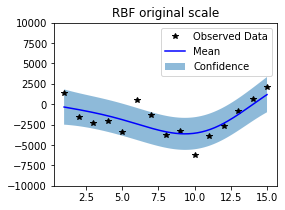

In [702]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.set_title("RBF original scale")
    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    lower = lower
    upper = upper
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(xstar.numpy(), y_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### OU

In [703]:
model = OU_model
test_x = xstar
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(model(test_x))


f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))
f_samples_unnormed = denorm(f_samples)

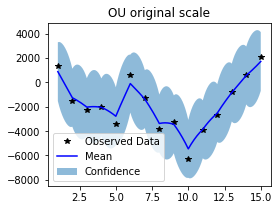

In [704]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.set_title("OU original scale")
    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    # lower = denorm(lower)
    # upper = denorm(upper)
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(xstar.numpy(), y_preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10, 10])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### Plot two together

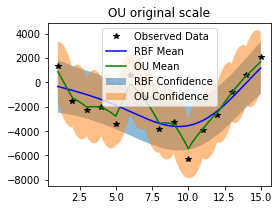

In [705]:
# def make_prediction(model,test_x=xstar):
model = rbf_model
test_x = xstar
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))
f_samples_unnormed = denorm(f_samples)

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.set_title("RBF original scale")
    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    lower = lower 
    upper = upper 
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(xstar.numpy(), y_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    
model = OU_model
test_x = xstar
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(model(test_x))


f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))
f_samples_unnormed = denorm(f_samples)


with torch.no_grad():
    # Initialize plot
    # f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.set_title("OU original scale")
    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    # lower = denorm(lower)
    # upper = denorm(upper)
    # Plot training data as black stars
    # ax.plot(x.numpy(), y_zero_centered.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(xstar.numpy(), y_preds.mean.numpy(), 'g')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10, 10])
    ax.legend(['Observed Data', 'RBF Mean', 'OU Mean', "RBF Confidence", "OU Confidence"])

## posterior sampling

Text(0, 0.5, 'y')

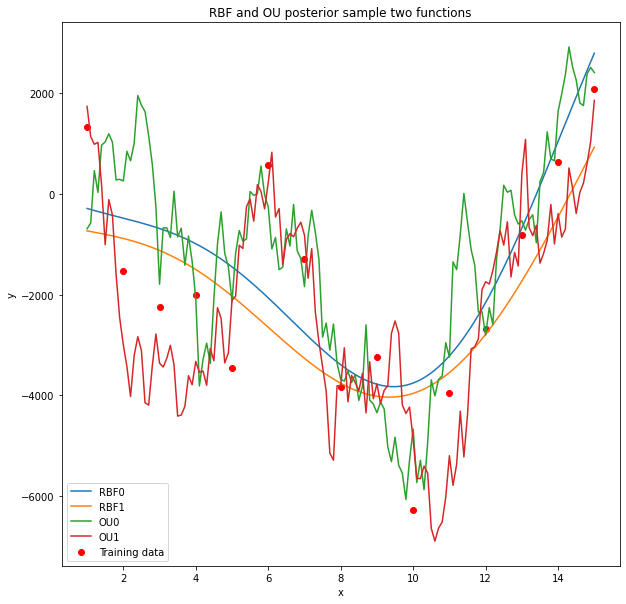

In [706]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = 900 ** 2


model = rbf_model
model.eval()
preds = model(xstar)
# take two samples from the posterior
samples = preds.sample(sample_shape=torch.Size((2,))) 

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("RBF and OU posterior sample two functions")
for i in range(2):
    sample_series = samples[i]
    ax.plot(xstar.numpy(), sample_series.numpy(), label='RBF' + str(i))
model = OU_model
model.eval()
preds = model(xstar)
# take two samples from the posterior
samples = preds.sample(sample_shape=torch.Size((2,))) 

for i in range(2):
    sample_series = samples[i]
    ax.plot(xstar.numpy(), sample_series.numpy(), label='OU' + str(i))


plt.scatter(x, y, color='r', label='Training data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# Learning Kernel Hyperparameters

## (a)

### RBF Training

In [235]:
x = x.cuda()
xstar = xstar.cuda()
y = y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

In [236]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine
model = ExactGPModel(x, y, likelihood,  gpytorch.kernels.RBFKernel()).cuda()
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

#### model_train function

In [237]:
# set eps according to step size
def model_train(model, mll, optimizer, x, y, eps=1e-2, log_step=1000):
    def train_log():
        if model.scale:
            print(f'Iter {step:5d} - Loss: {loss.item():.3f} ',
                      "l:", model.covar_module.lengthscale, 
                      f'a: {model.covar_module.outputscale.item()}, '
                      f'noise: {model.likelihood.noise.item():.3f}')
        else:
            print(f'Iter {step:5d} - Loss: {loss.item():.3f} ',
                      "l:", model.covar_module.lengthscale, 
                      # f'a: {model.covar_module.outputscale.item()}, '
                      f'noise: {model.likelihood.noise.item():.3f}')
    last_step_loss = np.inf
    loss = 0
    step = 0

    while abs(last_step_loss - loss) > eps:
        step += 1
        optimizer.zero_grad()
        output = model(x)

        last_step_loss = loss
        loss = -mll(output, y)

        loss.backward()
        optimizer.step()

        if step % log_step == 0:
            train_log()
    # final print
    train_log()

In [238]:
model_train(model, mll, optimizer, x, y)

Iter  1000 - Loss: 50644.623  l: None a: 51.235504150390625, noise: 6.264
Iter  2000 - Loss: 33591.448  l: None a: 78.10968017578125, noise: 6.846
Iter  3000 - Loss: 25434.720  l: None a: 102.59162902832031, noise: 7.392
Iter  4000 - Loss: 20239.941  l: None a: 127.50154113769531, noise: 7.962
Iter  5000 - Loss: 16509.492  l: None a: 154.1551971435547, noise: 8.591
Iter  6000 - Loss: 13662.021  l: None a: 183.42034912109375, noise: 9.306
Iter  7000 - Loss: 11415.109  l: None a: 215.9536590576172, noise: 10.137
Iter  8000 - Loss: 9608.812  l: None a: 252.26666259765625, noise: 11.118
Iter  9000 - Loss: 8141.326  l: None a: 292.7360534667969, noise: 12.292
Iter 10000 - Loss: 6941.783  l: None a: 337.59429931640625, noise: 13.713
Iter 11000 - Loss: 5957.492  l: None a: 386.9190979003906, noise: 15.455
Iter 12000 - Loss: 5147.451  l: None a: 440.6349792480469, noise: 17.616
Iter 13000 - Loss: 4478.813  l: None a: 498.5301818847656, noise: 20.333
Iter 14000 - Loss: 3924.887  l: None a: 560.

### RBF Eval

In [239]:
test_x = xstar
test_x = test_x.cuda()
# print(test_x)
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))
f_samples_unnormed = denorm(f_samples)

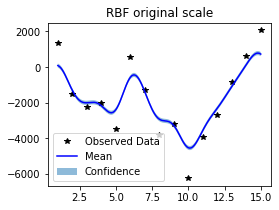

In [240]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

xstar = xstar.cpu()
y_mean = y_mean.cpu()
x = x.cpu()
y = y.cpu()
y_pred_mean = y_preds.mean.cpu()
# y_preds = y_preds.
# y_preds.cuda()

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.set_title("RBF original scale")
    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    lower = lower 
    upper = upper 
    lower = lower.cpu()
    upper = upper.cpu()
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(xstar.numpy(), y_pred_mean , 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xstar.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### OU Training

In [250]:
x = x.cuda()
y = y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

In [253]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine OU model
model = ExactGPModel(x, y, likelihood, OUKernel()).cuda()
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [254]:
model_train(model, mll, optimizer, x, y)

Iter  1000 - Loss: 56594.164  l: None a: 29.260683059692383, noise: 17.311
Iter  2000 - Loss: 37639.121  l: None a: 43.455142974853516, noise: 25.593
Iter  3000 - Loss: 28494.245  l: None a: 56.65349578857422, noise: 33.345
Iter  4000 - Loss: 22660.175  l: None a: 70.27571868896484, noise: 41.390
Iter  5000 - Loss: 18458.977  l: None a: 85.06432342529297, noise: 50.175
Iter  6000 - Loss: 15237.597  l: None a: 101.5698471069336, noise: 60.049
Iter  7000 - Loss: 12679.951  l: None a: 120.27377319335938, noise: 71.342
Iter  8000 - Loss: 10608.458  l: None a: 141.62989807128906, noise: 84.389
Iter  9000 - Loss: 8911.392  l: None a: 166.07412719726562, noise: 99.556
Iter 10000 - Loss: 7512.009  l: None a: 194.0193634033203, noise: 117.244
Iter 11000 - Loss: 6354.021  l: None a: 225.8358154296875, noise: 137.902
Iter 12000 - Loss: 5394.163  l: None a: 261.82525634765625, noise: 162.016
Iter 13000 - Loss: 4598.037  l: None a: 302.1914367675781, noise: 190.106
Iter 14000 - Loss: 3937.689  l: N

### OU Eval

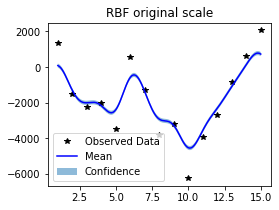

In [255]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

xstar = xstar.cpu()
y_mean = y_mean.cpu()
x = x.cpu()
y = y.cpu()
y_pred_mean = y_preds.mean.cpu()
# y_preds = y_preds.
# y_preds.cuda()

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.set_title("RBF original scale")
    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    lower = lower 
    upper = upper 
    lower = lower.cpu()
    upper = upper.cpu()
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(xstar.numpy(), y_pred_mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xstar.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### Comment
Explain why or why not there may be any significant differences in this particular case.

The final result kernel parameter is different from the prior setting. But the final learning result is quite similar to each other and no significant differences. The reason is that there is high noise in the data, thus the model tends to fit the data with high noise and less correlation between data points, which makes these kernels less different.

## (b)

###  Load Data

In [270]:
io.loadmat("./data/2dfunc.mat").keys()

dict_keys(['__header__', '__version__', '__globals__', 'x', 'y'])

In [271]:
data = io.loadmat("./data/2dfunc.mat")
x = torch.Tensor(data['x']).squeeze()
y = torch.Tensor(data['y']).squeeze()
print(x.shape, y.shape)

torch.Size([121, 2]) torch.Size([121])


In [272]:
x[1]

tensor([-3.0000, -2.4000])

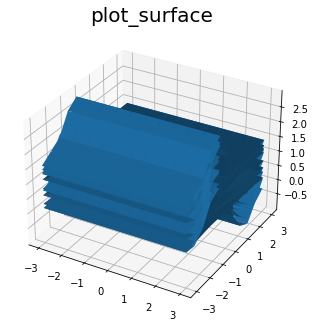

In [291]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def f(x, y):
    return (1 - y**5 + x**5)*np.exp(-x**2-y**2)

fig = plt.figure()
ax = Axes3D(fig)
X = x[:,0]
Y = x[:,1]
Z = y
Z = np.expand_dims(Z,1)
# Z = np.expand_dims(Z,1)
# print(Z)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
plt.title("plot_surface", fontsize=20, fontname="Times New Roman")
plt.show()

**I guess there is some format error in plot_surface**

In [395]:
def plot_trisurf_figure(Z=y, title=None, lower=None, upper=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    X = x[:,0]
    Y = x[:,1]
    # Z = y
    ax.scatter(x[:, 0], x[:, 1], y,label='parametric curve')
    # cmap=plt.cm.jet
    surface = ax.plot_trisurf(X, Y, Z, linewidth=0.1,label='parametric curve')
    # surface.set_label('Label via method')
    if lower is not None:
        ax.plot_trisurf(X, Y, lower, linewidth=0.1)
        ax.plot_trisurf(X, Y, upper, linewidth=0.1)
    # ax.add_collection3d()
        # fill_between_3d(ax,X,Y,lower,X,Y,upper, c="pink")
    # plt.fill_between(X, Y, lower.detach().numpy(), upper.detach().numpy(), color='orange', alpha=0.3,label="filled plot")
    # ax.fill_between(X.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    # ax.legend([surface],["observe samples"])
    if title is not None:
        plt.title(title)
    else:
        plt.title('plot_trisurf')

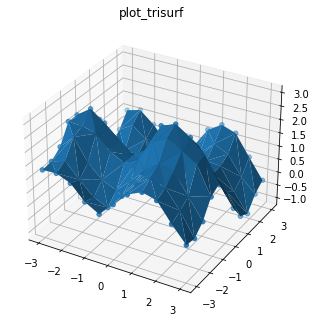

In [396]:
plot_trisurf_figure()

### RBF

In [368]:
print(x.shape, y.shape)

torch.Size([121, 2]) torch.Size([121])


In [299]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine
model = ExactGPModel(x, y, likelihood, gpytorch.kernels.RBFKernel(), scale=False)
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

I tried using the scale output, but hard to fit.

In [302]:
model_train(model, mll, optimizer, x, y, eps=1e-6, log_step=100)

Iter   100 - Loss: 1.105  l: tensor([[0.7434]], grad_fn=<SoftplusBackward>) noise: 0.644
Iter   200 - Loss: 1.050  l: tensor([[0.7935]], grad_fn=<SoftplusBackward>) noise: 0.596
Iter   300 - Loss: 0.999  l: tensor([[0.8436]], grad_fn=<SoftplusBackward>) noise: 0.550
Iter   400 - Loss: 0.949  l: tensor([[0.8935]], grad_fn=<SoftplusBackward>) noise: 0.507
Iter   500 - Loss: 0.901  l: tensor([[0.9434]], grad_fn=<SoftplusBackward>) noise: 0.465
Iter   600 - Loss: 0.855  l: tensor([[0.9930]], grad_fn=<SoftplusBackward>) noise: 0.426
Iter   700 - Loss: 0.810  l: tensor([[1.0421]], grad_fn=<SoftplusBackward>) noise: 0.390
Iter   800 - Loss: 0.766  l: tensor([[1.0903]], grad_fn=<SoftplusBackward>) noise: 0.355
Iter   900 - Loss: 0.723  l: tensor([[1.1370]], grad_fn=<SoftplusBackward>) noise: 0.324
Iter  1000 - Loss: 0.681  l: tensor([[1.1818]], grad_fn=<SoftplusBackward>) noise: 0.295
Iter  1100 - Loss: 0.640  l: tensor([[1.2239]], grad_fn=<SoftplusBackward>) noise: 0.268
Iter  1200 - Loss: 0.

In [303]:
test_x = x
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))
# f_samples_unnormed = denorm(f_samples)

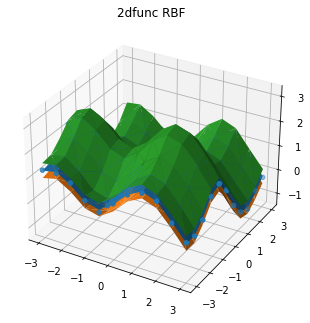

In [372]:
y_preds_mean = y_preds.mean
y_preds_mean = y_preds_mean.detach()
lower, upper = y_preds.confidence_region()
lower = lower.detach()
upper = upper.detach()
plot_trisurf_figure(Z=y_preds_mean, title="2dfunc RBF",lower=lower,upper=upper)

orange and green is the confidence region boundary

### ARD

In [362]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.train()

# redefine
model = ExactGPModel(x, y, likelihood, gpytorch.kernels.RBFKernel(ard_num_dims=x.shape[1]), scale=False)
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [337]:
model_train(model, mll, optimizer, x, y, eps=1e-6, log_step=100)

Iter   100 - Loss: 1.105  l: tensor([[0.7434, 0.7434]], grad_fn=<SoftplusBackward>) noise: 0.644
Iter   200 - Loss: 1.050  l: tensor([[0.7935, 0.7936]], grad_fn=<SoftplusBackward>) noise: 0.596
Iter   300 - Loss: 0.999  l: tensor([[0.8434, 0.8437]], grad_fn=<SoftplusBackward>) noise: 0.550
Iter   400 - Loss: 0.949  l: tensor([[0.8931, 0.8939]], grad_fn=<SoftplusBackward>) noise: 0.507
Iter   500 - Loss: 0.901  l: tensor([[0.9427, 0.9441]], grad_fn=<SoftplusBackward>) noise: 0.465
Iter   600 - Loss: 0.855  l: tensor([[0.9918, 0.9942]], grad_fn=<SoftplusBackward>) noise: 0.426
Iter   700 - Loss: 0.810  l: tensor([[1.0402, 1.0440]], grad_fn=<SoftplusBackward>) noise: 0.390
Iter   800 - Loss: 0.766  l: tensor([[1.0874, 1.0931]], grad_fn=<SoftplusBackward>) noise: 0.355
Iter   900 - Loss: 0.723  l: tensor([[1.1329, 1.1412]], grad_fn=<SoftplusBackward>) noise: 0.324
Iter  1000 - Loss: 0.681  l: tensor([[1.1761, 1.1876]], grad_fn=<SoftplusBackward>) noise: 0.295
Iter  1100 - Loss: 0.640  l: t

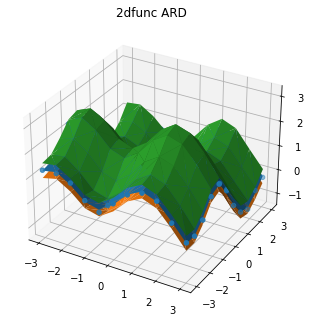

In [375]:
y_preds_mean = y_preds.mean
y_preds_mean = y_preds_mean.detach()
lower, upper = y_preds.confidence_region()
lower = lower.detach()
upper = upper.detach()
plot_trisurf_figure(Z=y_preds_mean, title="2dfunc ARD",lower=lower,upper=upper)

### Comment
Comment on the fit. How much noise is in the data?  Instead fit the data without ARD and comment on the difference.  What is the relative probability of a GP with the **{ard}** and **{rbf}** kernels (note in the RBF kernel the length-scale is the same for each dimension)

The noise term is around 0.012.

ARD will learn different scale in different direction, and the final ARD model is less noisy. Emprically, ARD give more freedom to the model learning and fit the data better.

ARD with lower loss which means better data fit.

But the final results is quite similar.

#### Relative Probability
What is the relative probability of a GP with the \texttt{ard} and \texttt{rbf} kernels
\begin{equation}
\frac{p\left(M_{1} \mid \mathbf{X}\right)}{p\left(M_{2} \mid \mathbf{X}\right)}=\frac{p\left(M_{1}\right)}{p\left(M_{2}\right)} \frac{p\left(\mathbf{X} \mid M_{1}\right)}{p\left(\mathbf{X} \mid M_{2}\right)}
\end{equation}

In [574]:
Loss_RBF = -0.160
MLL_RBF = -Loss_RBF
Loss_ARD = -0.166
MLL_ARD = -Loss_ARD

In [577]:
print(MLL_RBF/(MLL_RBF+MLL_ARD))
print(MLL_ARD/(MLL_RBF+MLL_ARD))

0.49079754601226994
0.5092024539877301


The relative probability of RBF is 0.4908, the relative probability of ard is 0.5092.

## (c)Bonus: Generate Data and test (we follow the tutorial: https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html#Introduction)

In [628]:
import math

In [629]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [630]:
# We will use the simplest form of GP model, exact inference
class BonusExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(BonusExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

model = BonusExactGPModel(train_x, train_y, likelihood)

In [632]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    log_step = 100
    if i % log_step == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()
print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    i + 1, training_iter, loss.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item()
))

Iter 1/100 - Loss: -0.079   lengthscale: 0.180   noise: 0.037
Iter 100/100 - Loss: -0.079   lengthscale: 0.179   noise: 0.037


\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04)
\end{align}


The noise ground truth is 0.04, our learning result is 0.042

### Large Noise Prior

In [633]:
# We will use the simplest form of GP model, exact inference
class BonusExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(BonusExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

model = BonusExactGPModel(train_x, train_y, likelihood)

In [635]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    log_step = 100
    if i % log_step == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()
print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    i + 1, training_iter, loss.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item()
))

Iter 1/100 - Loss: 7.721   lengthscale: 0.693   noise: 809987.500
Iter 100/100 - Loss: 7.721   lengthscale: 0.693   noise: 809975.000


#### Analysis

We give a very large noise to the model, and the model almost can not learn anything. So the initial noise will leed to different learning result

### Large Lengthscale Prior

In [636]:
# We will use the simplest form of GP model, exact inference
class BonusExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(BonusExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

model = BonusExactGPModel(train_x, train_y, likelihood)
model.covar_module.base_kernel.lengthscale = 1000

In [638]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    log_step = 100
    if i % log_step == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()
print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    i + 1, training_iter, loss.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item()
))

Iter 1/2000 - Loss: 1.129   lengthscale: 999.288   noise: 0.559
Iter 101/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 201/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 301/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 401/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 501/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 601/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 701/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 801/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 901/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 1001/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 1101/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 1201/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 1301/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 1401/2000 - Loss: 1.128   lengthscale: 999.288   noise: 0.559
Iter 15

#### Analysis

We give a large length scale prior to the model, which can also lead to the inability of the model learning. We can use some optimization method to overcome this, but it would be very hard. So we need a good prior for a good optimization start point.

# Learning the kernel

In [398]:
io.loadmat("./data/airline.mat").keys()

dict_keys(['__header__', '__version__', '__globals__', 'ytrain', 'ytest', 'xtest', 'xtrain'])

In [399]:
data = io.loadmat("./data/airline.mat")
x_train = torch.Tensor(data['xtrain']).squeeze()
y_train = torch.Tensor(data['ytrain'].astype(int)).squeeze()
x_test = torch.Tensor(data['xtest']).squeeze()
y_test = torch.Tensor(data['ytest'].astype(int)).squeeze()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([96]) torch.Size([96]) torch.Size([48]) torch.Size([48])


## Visulize

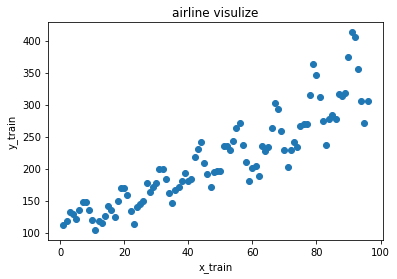

In [400]:
plt.scatter(x_train, y_train)
plt.title('airline visulize')
plt.xlabel('x_train')
plt.ylabel('y_train');

Consider using time-period kernel

extrapolation## ExactGPModelWithMultipleKernl

In [401]:
class ExactGPModelWithMultipleKernl(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel=gpytorch.kernels.RBFKernel()):
        super().__init__(train_x, train_y, likelihood)
        self.scale = False
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## RBF Kernel Only

In [420]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine
kernel=gpytorch.kernels.RBFKernel()
model = ExactGPModelWithMultipleKernl(x_train, y_train, likelihood, kernel=kernel)
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [421]:
model_train(model, mll, optimizer, x=x_train,y=y_train, eps=1e-4, log_step=1000)

Iter  1000 - Loss: 434.084  l: tensor([[11.8248]], grad_fn=<SoftplusBackward>) noise: 15.533
Iter  2000 - Loss: 215.013  l: tensor([[15.5529]], grad_fn=<SoftplusBackward>) noise: 22.661
Iter  3000 - Loss: 117.929  l: tensor([[17.7646]], grad_fn=<SoftplusBackward>) noise: 28.333
Iter  4000 - Loss: 71.344  l: tensor([[19.0531]], grad_fn=<SoftplusBackward>) noise: 33.417
Iter  5000 - Loss: 51.419  l: tensor([[19.7683]], grad_fn=<SoftplusBackward>) noise: 38.629
Iter  6000 - Loss: 43.381  l: tensor([[20.2573]], grad_fn=<SoftplusBackward>) noise: 44.768
Iter  7000 - Loss: 38.540  l: tensor([[20.7597]], grad_fn=<SoftplusBackward>) noise: 52.493
Iter  8000 - Loss: 34.216  l: tensor([[21.3301]], grad_fn=<SoftplusBackward>) noise: 62.207
Iter  9000 - Loss: 30.211  l: tensor([[21.9356]], grad_fn=<SoftplusBackward>) noise: 74.200
Iter 10000 - Loss: 26.602  l: tensor([[22.5285]], grad_fn=<SoftplusBackward>) noise: 88.769
Iter 11000 - Loss: 23.416  l: tensor([[23.0627]], grad_fn=<SoftplusBackward>)

In [405]:
# def make_prediction(model,test_x=xstar):
# model = rbf_model
test_x = x_test
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))



# test_x = x_test
model.eval()
likelihood.eval()
f_preds_train = model(x_train)
y_preds_train = likelihood(f_preds_train)


# f_samples_unnormed = denorm(f_samples)

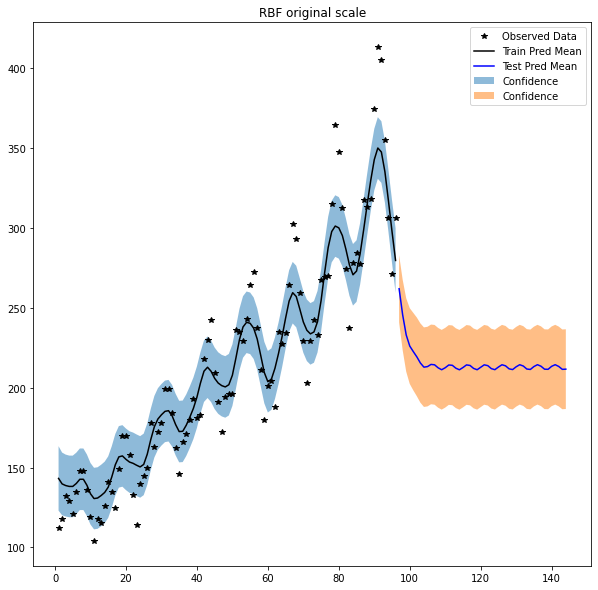

In [419]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title("RBF original scale")
    # Get upper and lower confidence bounds

    
    lower, upper = y_preds_train.confidence_region()
    lower = lower 
    upper = upper 
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_train.numpy(), y_preds_train.mean, 'k')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    lower, upper = y_preds.confidence_region()
    lower = lower 
    upper = upper 
    ax.plot(x_test.numpy(), y_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Train Pred Mean', 'Test Pred Mean','Confidence','Confidence'])

## Kernel Combination

In [408]:
x_test.shape[0]

48

In [423]:
per_kernel = gpytorch.kernels.PeriodicKernel()
kernel_dict = {
    "BM": BMKernel(),
    "RBF": gpytorch.kernels.RBFKernel(),
    "ARD": gpytorch.kernels.RBFKernel(ard_num_dims=x_test.shape[0]),
    "OU": OUKernel(),
    "PER": per_kernel,
    "IQ": IQKernel()
}

### PER + RBF

In [410]:
kernel = gpytorch.kernels.ScaleKernel(kernel_dict["PER"]) + gpytorch.kernels.ScaleKernel(kernel_dict["RBF"])

In [411]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine
# kernel=gpytorch.kernels.RBFKernel()
model = ExactGPModelWithMultipleKernl(x_train, y_train, likelihood, kernel=kernel)
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [413]:
model_train(model, mll, optimizer, x=x_train,y=y_train, eps=1e-4, log_step=1000)

Iter  1000 - Loss: 58.513  l: None noise: 12.477
Iter  2000 - Loss: 36.951  l: None noise: 18.781
Iter  3000 - Loss: 26.863  l: None noise: 24.599
Iter  4000 - Loss: 20.841  l: None noise: 30.594
Iter  5000 - Loss: 16.971  l: None noise: 37.107
Iter  6000 - Loss: 14.407  l: None noise: 44.399
Iter  7000 - Loss: 12.601  l: None noise: 52.705
Iter  8000 - Loss: 11.203  l: None noise: 62.249
Iter  9000 - Loss: 10.061  l: None noise: 73.270
Iter  9465 - Loss: 9.599  l: None noise: 78.956


In [414]:
# def make_prediction(model,test_x=xstar):
# model = rbf_model
test_x = x_test
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))



# test_x = x_test
model.eval()
likelihood.eval()
f_preds_train = model(x_train)
y_preds_train = likelihood(f_preds_train)


# f_samples_unnormed = denorm(f_samples)

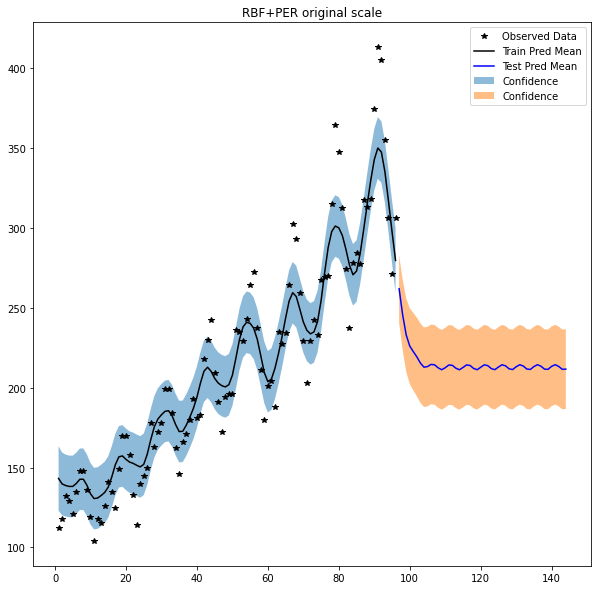

In [418]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title("RBF+PER original scale")
    # Get upper and lower confidence bounds

    
    lower, upper = y_preds_train.confidence_region()
    lower = lower
    upper = upper
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_train.numpy(), y_preds_train.mean, 'k')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    lower, upper = y_preds.confidence_region()
    lower = lower
    upper = upper
    ax.plot(x_test.numpy(), y_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Train Pred Mean', 'Test Pred Mean','Confidence','Confidence'])

### PER + RBF + OU

In [425]:
kernel = gpytorch.kernels.ScaleKernel(kernel_dict["PER"]) + gpytorch.kernels.ScaleKernel(kernel_dict["RBF"]) + gpytorch.kernels.ScaleKernel(kernel_dict["OU"])

In [426]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine
# kernel=gpytorch.kernels.RBFKernel()
model = ExactGPModelWithMultipleKernl(x_train, y_train, likelihood, kernel=kernel)
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [427]:
model_train(model, mll, optimizer, x=x_train,y=y_train, eps=1e-4, log_step=1000)

Iter  1000 - Loss: 40.401  l: None noise: 12.834
Iter  2000 - Loss: 24.552  l: None noise: 19.366
Iter  3000 - Loss: 17.682  l: None noise: 25.298
Iter  4000 - Loss: 13.733  l: None noise: 31.384
Iter  5000 - Loss: 11.272  l: None noise: 37.982
Iter  6000 - Loss: 9.706  l: None noise: 45.337
Iter  7000 - Loss: 8.671  l: None noise: 53.660
Iter  8000 - Loss: 7.915  l: None noise: 63.145
Iter  9000 - Loss: 7.308  l: None noise: 73.964
Iter 10000 - Loss: 6.809  l: None noise: 86.256
Iter 11000 - Loss: 6.397  l: None noise: 100.125
Iter 12000 - Loss: 6.060  l: None noise: 115.615
Iter 13000 - Loss: 5.785  l: None noise: 132.683
Iter 14000 - Loss: 5.563  l: None noise: 151.163
Iter 14660 - Loss: 5.441  l: None noise: 163.964


In [428]:
# def make_prediction(model,test_x=xstar):
# model = rbf_model
test_x = x_test
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))



# test_x = x_test
model.eval()
likelihood.eval()
f_preds_train = model(x_train)
y_preds_train = likelihood(f_preds_train)


# f_samples_unnormed = denorm(f_samples)

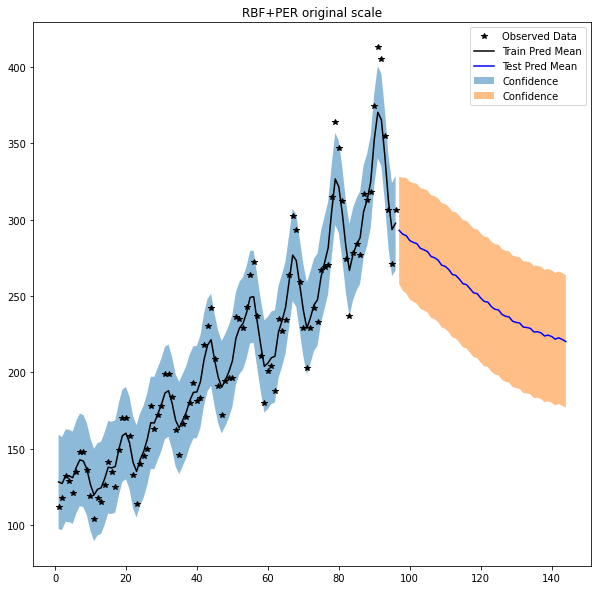

In [429]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title("RBF+PER original scale")
    # Get upper and lower confidence bounds

    
    lower, upper = y_preds_train.confidence_region()
    lower = lower
    upper = upper
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_train.numpy(), y_preds_train.mean, 'k')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    lower, upper = y_preds.confidence_region()
    lower = lower
    upper = upper
    ax.plot(x_test.numpy(), y_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Train Pred Mean', 'Test Pred Mean','Confidence','Confidence'])

In [441]:
for p in model.covar_module.kernels[0].parameters():
    print(p)

Parameter containing:
tensor(17.3646, requires_grad=True)
Parameter containing:
tensor([[9.5584]], requires_grad=True)
Parameter containing:
tensor([[0.0979]], requires_grad=True)


In [446]:
model.covar_module.kernels[0].base_kernel.lengthscale

tensor([[9.5585]], grad_fn=<SoftplusBackward>)

### PER + RBF +  PolynomialKernel

In [485]:
kernel = gpytorch.kernels.ScaleKernel(kernel_dict["PER"]) + gpytorch.kernels.ScaleKernel(kernel_dict["RBF"]) + gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power = 1))

In [486]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine
# kernel=gpytorch.kernels.RBFKernel()
model = ExactGPModelWithMultipleKernl(x_train, y_train, likelihood, kernel=kernel)
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [487]:
model_train(model, mll, optimizer, x=x_train,y=y_train, eps=1e-4, log_step=1000)

Iter  1000 - Loss: 11.991  l: None noise: 13.459
Iter  2000 - Loss: 9.049  l: None noise: 19.886
Iter  3000 - Loss: 7.712  l: None noise: 25.754
Iter  3042 - Loss: 7.671  l: None noise: 26.000


In [488]:
# def make_prediction(model,test_x=xstar):
# model = rbf_model
test_x = x_test
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))



# test_x = x_test
model.eval()
likelihood.eval()
f_preds_train = model(x_train)
y_preds_train = likelihood(f_preds_train)


# f_samples_unnormed = denorm(f_samples)

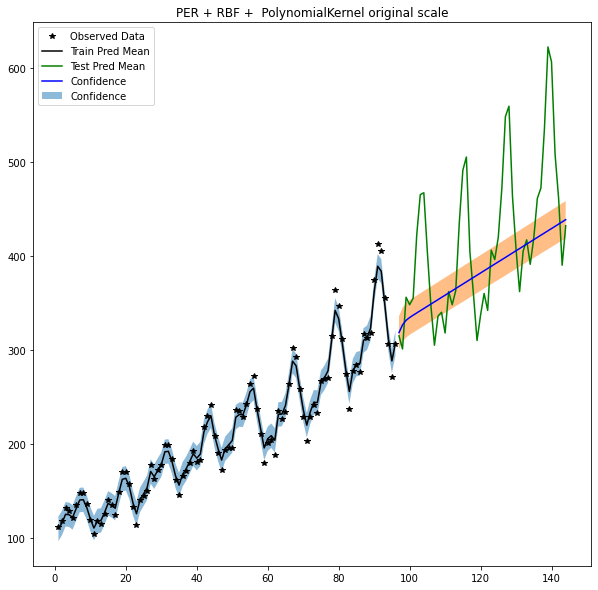

In [489]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title("PER + RBF +  PolynomialKernel original scale")
    # Get upper and lower confidence bounds

    
    lower, upper = y_preds_train.confidence_region()
    lower = lower
    upper = upper
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_train.numpy(), y_preds_train.mean, 'k')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    lower, upper = y_preds.confidence_region()
    lower = lower
    upper = upper
    ax.plot(x_test.numpy(), y_test, 'g')
    ax.plot(x_test.numpy(), y_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Train Pred Mean', 'Test Pred Mean','Confidence','Confidence'])

### PER + OU + RBF + PolynomialKernel

In [499]:
kernel = gpytorch.kernels.ScaleKernel(kernel_dict["PER"]) + gpytorch.kernels.ScaleKernel(kernel_dict["RBF"]) + gpytorch.kernels.ScaleKernel(kernel_dict["OU"]) + gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power = 1))

In [500]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine
# kernel=gpytorch.kernels.RBFKernel()
model = ExactGPModelWithMultipleKernl(x_train, y_train, likelihood, kernel=kernel)
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [501]:
model_train(model, mll, optimizer, x=x_train,y=y_train, eps=1e-4, log_step=1000)

Iter  1000 - Loss: 9.870  l: None noise: 13.241
Iter  2000 - Loss: 7.683  l: None noise: 19.455
Iter  3000 - Loss: 6.702  l: None noise: 25.061
Iter  3479 - Loss: 6.388  l: None noise: 27.729


In [493]:
# def make_prediction(model,test_x=xstar):
# model = rbf_model
test_x = x_test
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))



# test_x = x_test
model.eval()
likelihood.eval()
f_preds_train = model(x_train)
y_preds_train = likelihood(f_preds_train)


# f_samples_unnormed = denorm(f_samples)

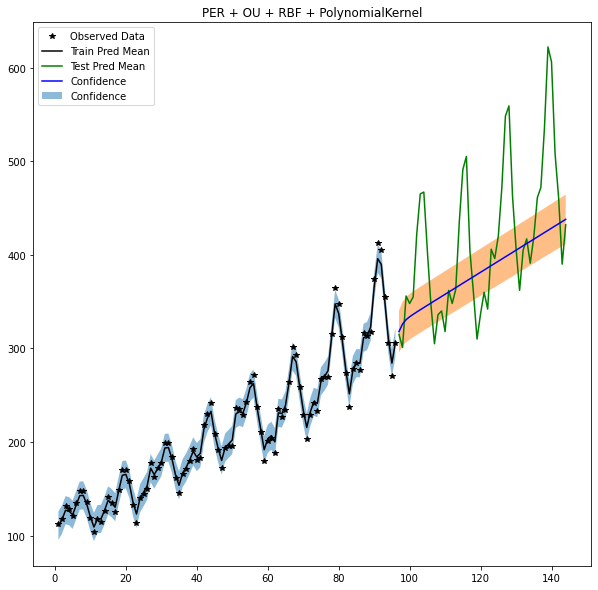

In [494]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title("PER + OU + RBF + PolynomialKernel")
    # Get upper and lower confidence bounds

    
    lower, upper = y_preds_train.confidence_region()
    lower = lower
    upper = upper
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_train.numpy(), y_preds_train.mean, 'k')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    lower, upper = y_preds.confidence_region()
    lower = lower
    upper = upper
    ax.plot(x_test.numpy(), y_test, 'g')
    ax.plot(x_test.numpy(), y_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Train Pred Mean', 'Test Pred Mean','Confidence','Confidence'])

### PER + OU + RBF + PolynomialKernel + Cosine

In [619]:
per_kernel = gpytorch.kernels.PeriodicKernel()
kernel_dict = {
        "BM": BMKernel(),
        "RBF": gpytorch.kernels.RBFKernel(),
        "ARD": gpytorch.kernels.RBFKernel(ard_num_dims=test_data.shape[1]),
        "OU": OUKernel(),
        "PER": per_kernel,
        "IQ": IQKernel()
    }

In [620]:
# kernel_dict["PER"].period_length_prior = 20
cosine_kernel = gpytorch.kernels.CosineKernel()
cosine_kernel.period_length_prior = 20
kernel = gpytorch.kernels.ScaleKernel(kernel_dict["PER"]) + gpytorch.kernels.ScaleKernel(kernel_dict["RBF"]) + gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power = 1)) + gpytorch.kernels.ScaleKernel(cosine_kernel) 

In [621]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.noise = 900 ** 2
likelihood.train()

# redefine
# kernel=gpytorch.kernels.RBFKernel()
model = ExactGPModelWithMultipleKernl(x_train, y_train, likelihood, kernel=kernel)
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [622]:
model_train(model, mll, optimizer, x=x_train,y=y_train, eps=1e-6, log_step=1000)

Iter  1000 - Loss: 37.603  l: None noise: 3.456
Iter  2000 - Loss: 17.921  l: None noise: 5.045
Iter  3000 - Loss: 14.120  l: None noise: 6.529
Iter  4000 - Loss: 11.713  l: None noise: 8.059
Iter  5000 - Loss: 10.160  l: None noise: 9.713
Iter  6000 - Loss: 8.912  l: None noise: 11.543
Iter  7000 - Loss: 7.966  l: None noise: 13.595
Iter  8000 - Loss: 7.300  l: None noise: 15.905
Iter  9000 - Loss: 6.928  l: None noise: 18.501
Iter 10000 - Loss: 6.391  l: None noise: 21.409
Iter 11000 - Loss: 5.978  l: None noise: 24.640
Iter 12000 - Loss: 5.479  l: None noise: 28.197
Iter 13000 - Loss: 5.304  l: None noise: 32.012
Iter 14000 - Loss: 5.104  l: None noise: 36.124
Iter 15000 - Loss: 4.943  l: None noise: 40.482
Iter 16000 - Loss: 4.817  l: None noise: 45.021
Iter 17000 - Loss: 4.715  l: None noise: 49.658
Iter 18000 - Loss: 4.634  l: None noise: 54.278
Iter 19000 - Loss: 4.563  l: None noise: 58.722
Iter 20000 - Loss: 4.510  l: None noise: 62.745
Iter 21000 - Loss: 4.466  l: None noise:

In [623]:
# def make_prediction(model,test_x=xstar):
# model = rbf_model
test_x = x_test
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))



# test_x = x_test
model.eval()
likelihood.eval()
f_preds_train = model(x_train)
y_preds_train = likelihood(f_preds_train)


# f_samples_unnormed = denorm(f_samples)

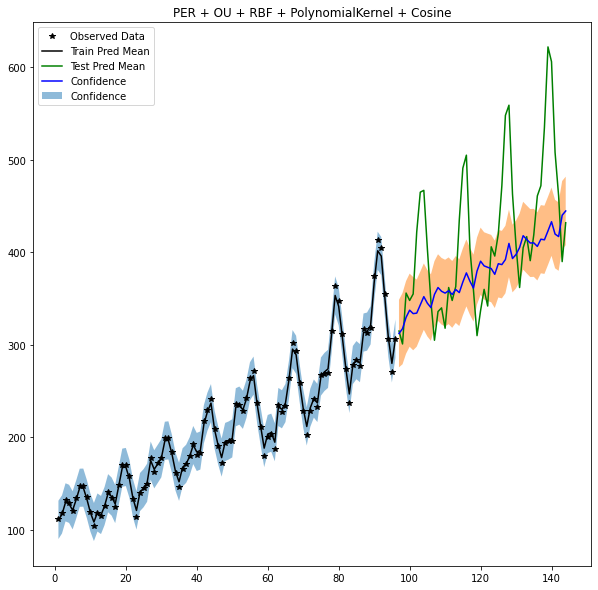

In [624]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title("PER + OU + RBF + PolynomialKernel + Cosine")
    # Get upper and lower confidence bounds

    
    lower, upper = y_preds_train.confidence_region()
    lower = lower
    upper = upper
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_train.numpy(), y_preds_train.mean, 'k')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    lower, upper = y_preds.confidence_region()
    lower = lower
    upper = upper
    ax.plot(x_test.numpy(), y_test, 'g')
    ax.plot(x_test.numpy(), y_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-10000, 10000])
    ax.legend(['Observed Data', 'Train Pred Mean', 'Test Pred Mean','Confidence','Confidence'])

## Show an extrapolation 20 years outside of the training data,

In [625]:
x_extrapolation = torch.range(x_train[0], x_train[-1] + 20 * 12 + 1)
x_extrapolation

tensor([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
         25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
         37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
         49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
         61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
         73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
         85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
         97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
        109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
        133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
        145., 146., 147., 148., 149., 15

In [626]:
# def make_prediction(model,test_x=xstar):
# model = rbf_model
test_x = x_extrapolation
model.eval()
likelihood.eval()
f_preds = model(test_x)
y_preds = likelihood(f_preds)
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

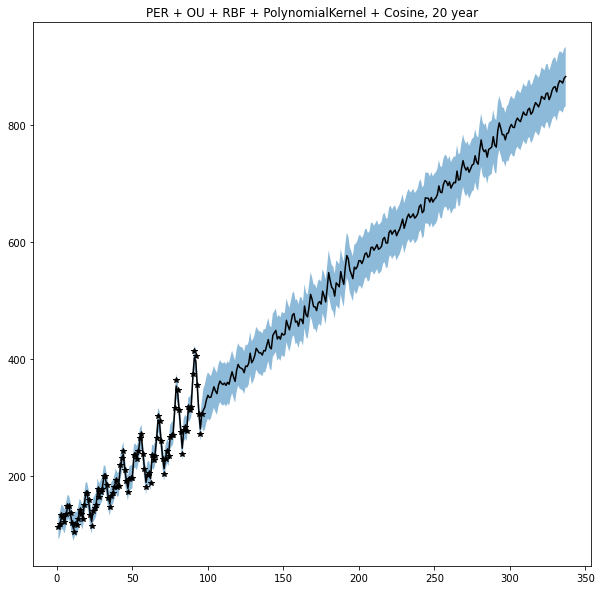

In [627]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title("PER + OU + RBF + PolynomialKernel + Cosine, 20 year")
    # Get upper and lower confidence bounds

    
    lower, upper = y_preds.confidence_region()
    lower = lower
    upper = upper
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_extrapolation.numpy(), y_preds.mean, 'k')
    ax.fill_between(x_extrapolation.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    # lower, upper = y_preds.confidence_region()
    # lower = lower
    # upper = upper
    # ax.plot(x_test.numpy(), y_test, 'g')
    # ax.plot(x_test.numpy(), y_preds.mean, 'b')
    # # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # # ax.set_ylim([-10000, 10000])
    # ax.legend(['Observed Data', 'Train Pred Mean', 'Test Pred Mean','Confidence','Confidence'])

## Comment

There are usually two trends of the learned results.

- 1.
Learned the global trend but less fit to the period local structure.

- 2.
Follow the previous local structure and the final curve going down.

I guess we can get a better fit via a better kernel choice, but I do not get it currently. 

The combination model learned result is more likely the first one, while the single kernel learning result is more like the second one.